# Linear Regression
## Ryan Keenan
## Chapter 8.1 to 8.5

## The Regression Problem
Finding the full PDF from which some data set was drawn is in general a very hard problem.

Regression instead solves a simpler problem - instead of finding the full PDF we only try to determine the expectation value of some dependent variable y given the values of the independent variables x. 
If we have a model with parameters $\theta_i$ we can write this as a function $y=f(x|\theta)$.

Each point $(x_i,y_i)$ in our observed data provides a constraint on the parameters $\theta$

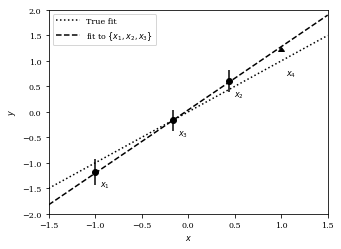

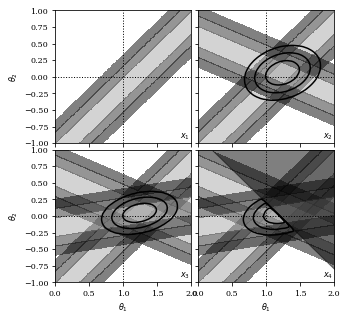

In [1]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Set up the data and errors
np.random.seed(13)
a = 1
b = 0

x = np.array([-1, 0.44, -0.16])
y = a * x + b
dy = np.array([0.25, 0.22, 0.2])

y = np.random.normal(y, dy)

# add a fourth point which is a lower bound
x4 = 1.0
y4 = a * x4 + b + 0.2

#------------------------------------------------------------
# Compute the likelihoods for each point
a_range = np.linspace(0, 2, 80)
b_range = np.linspace(-1, 1, 80)
logL = -((a_range[:, None, None] * x + b_range[None, :, None] - y) / dy) ** 2
sigma = [convert_to_stdev(logL[:, :, i]) for i in range(3)]

# compute best-fit from first three points
logL_together = logL.sum(-1)
i, j = np.where(logL_together == np.max(logL_together))
amax = a_range[i[0]]
bmax = b_range[j[0]]

#------------------------------------------------------------
# Plot the first figure: the points and errorbars
fig1 = plt.figure(figsize=(5, 3.75))
ax1 = fig1.add_subplot(111)

# Draw the true and best-fit lines
xfit = np.array([-1.5, 1.5])
ax1.plot(xfit, a * xfit + b, ':k', label='True fit')
ax1.plot(xfit, amax * xfit + bmax, '--k', label='fit to $\{x_1, x_2, x_3\}$')

ax1.legend(loc=2)

ax1.errorbar(x, y, dy, fmt='ok')
ax1.errorbar([x4], [y4], [[0.5], [0]], fmt='_k', lolims=True)

for i in range(3):
    ax1.text(x[i] + 0.05, y[i] - 0.3, "$x_{%i}$" % (i + 1))
ax1.text(x4 + 0.05, y4 - 0.5, "$x_4$")

ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-2, 2)

#------------------------------------------------------------
# Plot the second figure: likelihoods for each point
fig2 = plt.figure(figsize=(5, 5))
fig2.subplots_adjust(hspace=0.05, wspace=0.05)

# plot likelihood contours
for i in range(4):
    ax = fig2.add_subplot(221 + i)
    for j in range(min(i + 1, 3)):
        ax.contourf(a_range, b_range, sigma[j].T,
                    levels=(0, 0.683, 0.955, 0.997),
                    cmap=plt.cm.binary, alpha=0.5)

# plot the excluded area from the fourth point
axpb = a_range[:, None] * x4 + b_range[None, :]
mask = y4 < axpb
fig2.axes[3].fill_between(a_range, y4 - x4 * a_range, 2, color='k', alpha=0.5)

# plot ellipses
for i in range(1, 4):
    ax = fig2.axes[i]
    logL_together = logL[:, :, :i + 1].sum(-1)
    if i == 3:
        logL_together[mask] = -np.inf

    sigma_together = convert_to_stdev(logL_together)

    ax.contour(a_range, b_range, sigma_together.T,
               levels=(0.683, 0.955, 0.997),
               colors='k')

# Label and adjust axes
for i in range(4):
    ax = fig2.axes[i]

    ax.text(1.98, -0.98, "$x_{%i}$" % (i + 1), ha='right', va='bottom')

    ax.plot([0, 2], [0, 0], ':k', lw=1)
    ax.plot([1, 1], [-1, 1], ':k', lw=1)

    ax.set_xlim(0.001, 2)
    ax.set_ylim(-0.999, 1)

    if i in (1, 3):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    if i in (0, 1):
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    if i in (0, 2):
        ax.set_ylabel(r'$\theta_2$')
    if i in (2, 3):
        ax.set_xlabel(r'$\theta_1$')


plt.show()

## Likelihood for a Linear Model
As a first example it's illustrative to consider how to optimize the fit of a line to a set of data (as in the example above). If we have a set of data with known error behavior for the dependent variable and negligible errors for the independent variables then the posterior PDF for the model parameters will be

$$p(\theta | \{x_i,y_i\},I) \propto p(\{x_i,y_i\} | \theta, I)p(\theta,I)$$

where the information we have is the description of the error behavior of y. The likelihood of the data is the product of the likelihoods for each point which, assuming Gaussian errors, can be written as 

$$p(y_i | x_i,\theta,I) = \dfrac{1}{\sigma_i \sqrt{2\pi}} \exp{\dfrac{-(y_i-f(x_i|\theta))^2}{2\sigma_i^2}}$$

where $f(x_i|\theta)$ is the model we are fitting (in this case a line). Our goal is then to find the parameters $\theta$ that maximizes the likelihood of the data. If we have no information about the prior pdf (that is our $p{\theta,I}$ is flat, the task becomes maximizing

$$p(\{y_i\} | \{x_i\},\theta,I) = \prod_i \dfrac{1}{\sigma_i \sqrt{2\pi}} \exp{\dfrac{-(y_i-f(x_i|\theta))^2}{2\sigma_i^2}}$$

or equivalently maximizing

$$\ln(L) = \ln(p(\theta | \{x_i,y_i\}, I)) \propto \sum_i \dfrac{-(y_i-f(x_i|\theta))^2}{2\sigma_i^2}$$

That is, maximizing the log-likelihood is acomplished by maximizing the sum of the square errors, which gives rise to calling the technique the method of least squares.

For the case where $f(x_i|\theta) = \theta_0+\theta_1 x_i$ and the uncertainties are homoscedastic, this is minimized by 

$$\theta_1 = \dfrac{\sum_i x_i y_i - \bar x \bar y}{\sum_i (x_i-\bar x)^2}$$
$$\theta_0 = \bar y - \theta_1 \bar x$$

You can do this minimization by hand (there are plenty of places online showing how), but it's a lot of work, and for more complex errors and models it's better to formulate it in a different way.

## Matrix Formalism
It is generally easier to define the regression in terms of a "design matrix", M, which we construct such that

$$Y=M\theta$$

where Y is a vector of our n $y_i$ values, $\theta$ is a vector of our m model parameters, and M is an m x n matrix related to the functional form of our model. For the case of a line then we'd have 

$$\theta = \begin{bmatrix}
\theta_0 \\
\theta_1
\end{bmatrix}$$

$$M = \begin{bmatrix}
1 & x_0 \\
1 & x_1 \\
\vdots & \vdots \\
1 & x_n
\end{bmatrix}$$

We then define a covariance matrix C containing the uncertainties of each measurement of the independent variable

$$C = \begin{bmatrix}
\sigma_0^2 & 0 &\dots & 0 \\
0 & \sigma_1^2 &\dots & 0 \\
\vdots &\vdots &\ddots & \vdots \\
0 & 0 & \dots & \sigma_n^2
\end{bmatrix}$$

The maximum likelihood solution for $\theta$ will then be

$$\theta = (M^T C^{-1} M)^{-1} (M^T C^{-1} Y)$$

which is the minimization of the square errors $(Y-\theta M)^T C^{-1} (Y-\theta M)$.

The uncertainties on our parameters will then be given by the matrix

$$\Sigma_\theta = (M^T C^{-1} M)^{-1}$$

## Multiple Variables, More Complex Models
This formalism easily generalizes to multiple dependent variables and to more complex functional forms for our models. A linear function of k variables $f(x_1,...x_k | \theta) = \theta_0 + \theta_1 x_1 + ... + \theta_k x_k$ can be expressed using design matrix

$$M = \begin{bmatrix}
1 & x_{01} & \dots & x_{0k} \\
1 & x_{11} & \dots & x_{1k} \\
\vdots & \vdots & \ddots & \vdots \\
1 & x_{n1} & \dots & x_{nk}
\end{bmatrix}$$

Or a polynomial model $f(x | \theta) = \theta_0 + \theta_1 x + ... + \theta_k x^k$ can be written

$$M = \begin{bmatrix}
1 & x_0 & \dots & x_0^k \\
1 & x_1 & \dots & x_1^k \\
\vdots & \vdots & \ddots & \vdots \\
1 & x_n & \dots & x_n^k
\end{bmatrix}$$

In both cases the best fits and uncertainties for $\theta$ are still described by 

$$\theta = (M^T C^{-1} M)^{-1} (M^T C^{-1} Y)$$
$$\Sigma_\theta = (M^T C^{-1} M)^{-1}$$t

We can also allow for correlation between measures of the dependent variables by setting the off-diagonal terms of the covariance matrix to non-zero values.

This formalism can be used with any model which has a linear dependence on the model parameters $\theta$ - the regression is linear in these parameters, but can be polynomial, exponential, basis, etc. in its dependence on x.

## Categorizing Regression Problems
All of the above was done assuming that we understand the errors on our dependent variable and that the errors in our independent variables are negligible. This accounts for a large class of problems but not all of them. It is useful to be able to categorize regression problems.

The book provides a classification scheme for regression based on the following categories
- linearity - whether or not the model has a linear dependence in all of its parameters. That is, a linear model can be expressed in the form $f(x|\theta)=\sum_p\theta_p g_p(x)$ where none of the $g_p(x)$ have any dependence on $\theta$. If this is the case we can use linear regression. If not we will need nonlinear regression (see next talk).
- problem complexity - the larger the number of independent variables, the more complex the error covariance matrix becomes, and the more dificult the problem is to solve. This can be very problematic for nonlinear regression, but in the case of linear models with negligible errors on the independent variables it's not much of a concern.
- error behavior - this determines the structure of the error covariance matrix and is the primary determinant of what type of regression to use. We can break down types of error into a number of categories:
    1. negligible errors in all variables
    2. errors in the dependent variable are non-negligible, but known to be Gaussian and homoscedastic
    3. errors in the dependent variable are non-negligible, but known to be Gaussian and heteroscedastic
    4. errors in the dependent variable are non-Gaussian but have a known form.    
    5. errors in the dependent variable are non-Gaussian and their exact behavior is unknown
    6. errors in the independent variable cannot be ignored, but their full covariance matrix can be treated as Gaussian
    7. all variables have non-Gaussian errors
    
Case 1 is simple and easy to solve even with non-linear and multidimensional data.

For linear models cases 2 and 3 are already dealt with completely by the formalism for matrix regression described above. For case 4 the treatment is similar but we must adjust the functional form of the likelihood we seek to maximize. 

Cases 5 and 6 require more complex methods. Some of this will be dealt with in the next lecture. To preview, inclusion of error in the independent variable will create a bias in our parameter fitting. This can in some cases be resolved by transforming data axes, but for complex models that becomes too computationally taxing and we may have to resort to other approaches.

Case 7 is generally very difficult and there isn't a prescribed solution. It's usually solved by making approximations based on the specific problem at hand.

## A Few More Considerations
When choosing a model it is also important to consider what our data will allow us to do.
- Too simple a model will lack the flexibility to accurately fit important features of our data, resulting in underfitting
- But, if we arbitrarily increase the number of parameters (for example by using a high degree polynomial or basis function with many bases) then we risk overfitting the data - our model will fit closely to the points we use in optimizing it, but won't be able to accurately predict values at other points.

For low dimesnion data overfitting can be picked out visually (see below). A $\chi^2$ test can be a helpful starting point for identifying underfitting. For more advanced approaches see Section 8.11 (Cross-Validation).

/home/rpkeenan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:52: RankWarning: Polyfit may be poorly conditioned


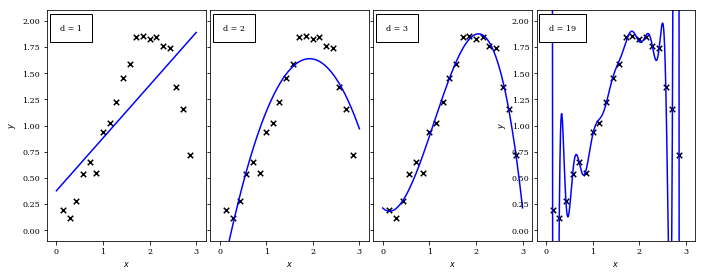

In [7]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.patches import FancyArrow

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# Second figure: plot fit for several orders of polynomial
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(wspace=0.03, bottom=0.15,
                    top=0.95, left=0.07, right=0.97)

for i, d in enumerate([1, 2, 3, 19]):
    ax = fig.add_subplot(141 + i)
    ax.scatter(x, y, marker='x', c='k', s=30)

    p = np.polyfit(x, y, d)
    y_fit = np.polyval(p, x_fit)

    ax.plot(x_fit, y_fit, '-b')
    ax.set_ylim(-0.1, 2.1)
    ax.set_xlim(-0.2, 3.2)
    if i in (1, 2):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    ax.text(0.08, 0.94, "d = %i" % d, transform=ax.transAxes,
            ha='left', va='top',
            bbox=dict(ec='k', fc='w', pad=10))

plt.show()



## Some Code
All of the regression techniques described so far can be implemented using code from sklear or astroML. The functions can be found described in the various code boxes in Chapter 8 of the book.

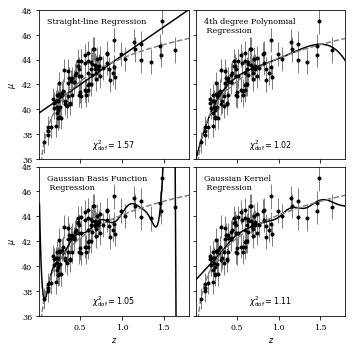

In [8]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression, PolynomialRegression,\
    BasisFunctionRegression, NadarayaWatson

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Generate data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = Cosmology()
z = np.linspace(0.01, 2, 1000)
mu_true = np.asarray(map(cosmo.mu, z))

#------------------------------------------------------------
# Define our classifiers
basis_mu = np.linspace(0, 2, 15)[:, None]
basis_sigma = 3 * (basis_mu[1] - basis_mu[0])

subplots = [221, 222, 223, 224]
classifiers = [LinearRegression(),
               PolynomialRegression(4),
               BasisFunctionRegression('gaussian',
                                       mu=basis_mu, sigma=basis_sigma),
               NadarayaWatson('gaussian', h=0.1)]
text = ['Straight-line Regression',
        '4th degree Polynomial\n Regression',
        'Gaussian Basis Function\n Regression',
        'Gaussian Kernel\n Regression']

# number of constraints of the model.  Because
# Nadaraya-watson is just a weighted mean, it has only one constraint
n_constraints = [2, 5, len(basis_mu) + 1, 1]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)

for i in range(4):
    ax = fig.add_subplot(subplots[i])

    # fit the data
    clf = classifiers[i]
    clf.fit(z_sample[:, None], mu_sample, dmu)

    mu_sample_fit = clf.predict(z_sample[:, None])
    mu_fit = clf.predict(z[:, None])

    chi2_dof = (np.sum(((mu_sample_fit - mu_sample) / dmu) ** 2)
                / (len(mu_sample) - n_constraints[i]))

    ax.plot(z, mu_fit, '-k')
    ax.plot(z, mu_true, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

    ax.text(0.5, 0.05, r"$\chi^2_{\rm dof} = %.2f$" % chi2_dof,
            ha='center', va='bottom', transform=ax.transAxes)

    ax.set_xlim(0.01, 1.8)
    ax.set_ylim(36.01, 48)
    ax.text(0.05, 0.95, text[i], ha='left', va='top',
            transform=ax.transAxes)

    if i in (0, 2):
        ax.set_ylabel(r'$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    if i in (2, 3):
        ax.set_xlabel(r'$z$')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

plt.show()

## Regularization
Least squares regression finds the minimum variance unbiased estimator, but sometimes this may not be the most appropriate regression. Such cases include when we have reason to expect parameters to be small or want to limit the number of degrees of freedom in our fit.

This leads to techniques called regularization. We impose a penalty on models that don't meet our expectations by adding a regularization term to the equation we seek to minimize. That is, instead of minimizing $(Y-\theta M)^T C^{-1} (Y-\theta M)$ we minimize

$$(Y-\theta M)^T C^{-1} (Y-\theta M)+\lambda \times f(\theta)$$

where $\lambda$ is the regularization parameter and f is the penalty function.

## Ridge Regression
Ridge regression uses the penalty function $|\theta^T\theta|$ and has the effect of penalizing large values of $\theta$. As $\lambda$ is increased $\theta$ is driven towards smaller and smaller values.

## LASSO Regression
Least absolute shrinkage and selection (LASSO) regression uses the penalty function $|\theta|$. Which penalizes the absolute value of the regression but also favors setting most parameters to zero or small values. This reduces model complexity and helps prevent overfitting.

These are also both implemented in sklearn.

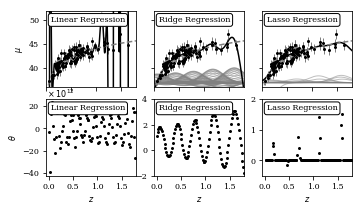

In [10]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import lognorm

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# generate data
np.random.seed(0)

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)
cosmo = Cosmology()

z = np.linspace(0.01, 2, 1000)
mu = np.asarray(map(cosmo.mu, z))


#------------------------------------------------------------
# Manually convert data to a gaussian basis
#  note that we're ignoring errors here, for the sake of example.
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

centers = np.linspace(0, 1.8, 100)
widths = 0.2
X = gaussian_basis(z_sample[:, np.newaxis], centers, widths)

#------------------------------------------------------------
# Set up the figure to plot the results
fig = plt.figure(figsize=(5, 2.7))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.15, wspace=0.2)

classifier = [LinearRegression, Ridge, Lasso]
kwargs = [dict(), dict(alpha=0.005), dict(alpha=0.001)]
labels = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']

for i in range(3):
    clf = classifier[i](fit_intercept=True, **kwargs[i])
    clf.fit(X, mu_sample)
    w = clf.coef_
    fit = clf.predict(gaussian_basis(z[:, None], centers, widths))

    # plot fit
    ax = fig.add_subplot(231 + i)
    ax.xaxis.set_major_formatter(plt.NullFormatter())

    # plot curves for regularized fits
    if i == 0:
        ax.set_ylabel('$\mu$')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        curves = 37 + w * gaussian_basis(z[:, np.newaxis], centers, widths)
        curves = curves[:, abs(w) > 0.01]
        ax.plot(z, curves,
                c='gray', lw=1, alpha=0.5)

    ax.plot(z, fit, '-k')
    ax.plot(z, mu, '--', c='gray')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, ms=4)
    ax.set_xlim(0.001, 1.8)
    ax.set_ylim(36, 52)
    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

    # plot weights
    ax = plt.subplot(234 + i)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax.set_xlabel('$z$')
    if i == 0:
        ax.set_ylabel(r'$\theta$')
        w *= 1E-12
        ax.text(0, 1.01, r'$\rm \times 10^{12}$',
                transform=ax.transAxes)
    ax.scatter(centers, w, s=9, lw=0, c='k')

    ax.set_xlim(-0.05, 1.8)

    if i == 1:
        ax.set_ylim(-2, 4)
    elif i == 2:
        ax.set_ylim(-0.5, 2)

    ax.text(0.05, 0.93, labels[i],
            ha='left', va='top',
            bbox=dict(boxstyle='round', ec='k', fc='w'),
            transform=ax.transAxes)

plt.show()

## PCR and Kernel Regression
Two more approaches to be aware of:
- Principle Component Regression projects the data onto its principle component eigenvectors (from PCA), and truncates the expansion to include only components with large eigenvalues. It then performs a linear regression. Works similar to ridge regression but helps to aleviate problems with data with are highly correlated independent variables.
- Kernel regression - uses only nearby points in fitting data by downweighting values further away. This solves problems with extrapolation that occur with polynomial fits that aren't well constrained at the edges of the data, but can result in poor weighting when there are changes in sample size over the range of data